#  Install package

In [269]:
# ! pip install pyvis
# ! pip install networkx

# Import package

In [270]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai


# Define Solution class
Please run the following cell to define the functions

In [271]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration 1: Resident living with hazardous wastes

## Input task and data desciption

In [281]:
print(DATA_LOCATIONS)

["ESRI shapefile for France administrative regions:https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip.The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.", "REST API url with parameters for mobility data access:http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020.The response is in CSV format. There are three columns in the response: place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code, France administrative regions start with 'FRA'."]


In [272]:
# Case 1: population living near hazardous waster
'''
TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilities.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
                  "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
                  "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
                 ]
'''

# Case 2: mobility data retrieval and visulization
"""
TASK = r'''
1) Show the monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions.

'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip." + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code, France administrative regions start with 'FRA'.",
                 ]

# Bug: 
# base_month =  "2020-01" # wrong: pd.to_datetime("2020-01")
# print(region_monthly[region_monthly['month_year'] == base_month])

"""

# Case 3: mobility data retrieval and visulization
TASK = r"""1) Find out the Autism service providers' addresses from their home pages. Their address usually listed in the 'about' or 'contact' page, you can crawl the links (in the homepage) contain 'about' or 'contact'.
2) The address shoul contain street, city, state, and zipcode. E.g., 1234 NW Bobcat Lane, St. Robert, MO 65584. If you cannot find the address, simply return nothing, DO NOT make up fake addresses. 
3) If cannot find the street address, the city, state, or zipcode are also need to return. In summary, find the address information as much as possible.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
                  "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
                  "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
                 ]


# TASK = r'''1)Retrieve the data from the REST API and plot the intra_movement column of the returned data as line chart to show the temporal trend of all states. 
# 2) plot the temporal trend of the movement for each state. Each state figure will be sub figure in the plot. The plot has 5 columns. In addition, please add a weekly smoothed line to each sub plot, and change the line color to orange.
# 3) Using the REST API with date range from 01/01/2020 to 12/31/2020 to analyze the movement reduction rate for each state during two periods: the first period is 01/01/2020-02/29/2020, second period is 03/01/2020 to 04/30/2020. Please find out the reduction rate for each state during the two periods, and create a table to report the result with two columns: state name, reduction rate, sorted by reduction rate.
# '''
# '''
# DATA_LOCATIONS = ["REST API url with parameters for data access: http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=us_state&begin=01/01/2020&end=12/31/2020; The response is in CSV format. There are three columns in the response: place,date,intra_movement; place refers to the state name."
#                  ]
# '''
# 3) Show the administrative region name in the map and chart.
# 
# task_name ='Resident_at_risk_counting'
task_name ='France_mobility_changes_2020'  

save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 
1) Show the monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions.

 
Data locations (each data is a node): 1. ESRI shapefile for France administrative regions:https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip.The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.
2. REST API url with parameters for mobility data access:http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020.The r

## Get graph code from GPT API

In [273]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()
print()
print("Code to generate solution graph: \n")
print(solution.code_for_graph)

Geting LLM reply...
Got LLM reply.

Code to generate solution graph: 

import networkx as nx

G = nx.DiGraph()

# 1. Load France administrative regions shapefile
G.add_node("france_shp_url", node_type="data", path="https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip", description="France administrative regions shapefile URL")
G.add_node("load_france_shp", node_type="operation", description="Load France administrative regions shapefile")
G.add_edge("france_shp_url", "load_france_shp")

G.add_node("france_gdf", node_type="data", description="France administrative regions GeoDataFrame")
G.add_edge("load_france_shp", "france_gdf")

# 2. Get mobility data from REST API
G.add_node("mobility_api_url", node_type="data", path="http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020", description="REST API URL for mobility data")
G.add_node("get_mobility_data", node_type="oper

## Execute code to generate the solution graphto generate the solution graph

In [274]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

E:\Research\LLM-Geo\France_mobility_changes_2020.html


## Generate prompts and code for operations (functions)

In [275]:
# with open(r'F:\Research\LLM-Geo\Resident_at_risk_counting\Resident_at_risk_counting.pkl', 'rb') as f:
#     solution = pickle.load(f)

In [276]:
operations = solution.get_LLM_responses_for_operations()
solution.save_solution()

# all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
# print("All operation code: \n")
# print(all_operation_code_str)

1 / 7, load_france_shp
Geting LLM reply...
Got LLM reply.
2 / 7, get_mobility_data
Geting LLM reply...
Got LLM reply.
3 / 7, filter_france_mobility_data
Geting LLM reply...
Got LLM reply.
4 / 7, calculate_monthly_change_rates
Geting LLM reply...
Got LLM reply.
5 / 7, join_change_rates
Geting LLM reply...
Got LLM reply.
6 / 7, generate_map_matrix
Geting LLM reply...
Got LLM reply.
7 / 7, create_line_chart
Geting LLM reply...
Got LLM reply.


## Generate prompts and code for assembly program

In [277]:
assembly_LLM_response = solution.get_LLM_assembly_response()
# solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

print("Assembly code: \n")
print(solution.code_for_assembly)

Geting LLM reply...
Got LLM reply.
def main():
    # Step 1: Load France administrative regions shapefile
    france_gdf = load_france_shp()

    # Step 2: Get mobility data from REST API
    mobility_data = get_mobility_data()

    # Step 3: Filter France mobility data
    france_mobility_data = filter_france_mobility_data(mobility_data)

    # Step 4: Calculate monthly change rates
    monthly_change_rates = calculate_monthly_change_rates(france_mobility_data)

    # Step 5: Join change rates to France GeoDataFrame
    france_gdf_change_rates = join_change_rates(france_gdf, monthly_change_rates)

    # Step 6: Generate a map matrix showing the monthly change rates
    map_matrix = generate_map_matrix(france_gdf_change_rates)

    # Save the generated map matrix as a png file
    map_matrix.savefig('france_monthly_change_rates_map_matrix.png', bbox_inches='tight')

    # Step 7: Create a line chart showing the monthly change rate trends
    line_chart = create_line_chart(monthly_chang

## Execute assembly code

<string>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


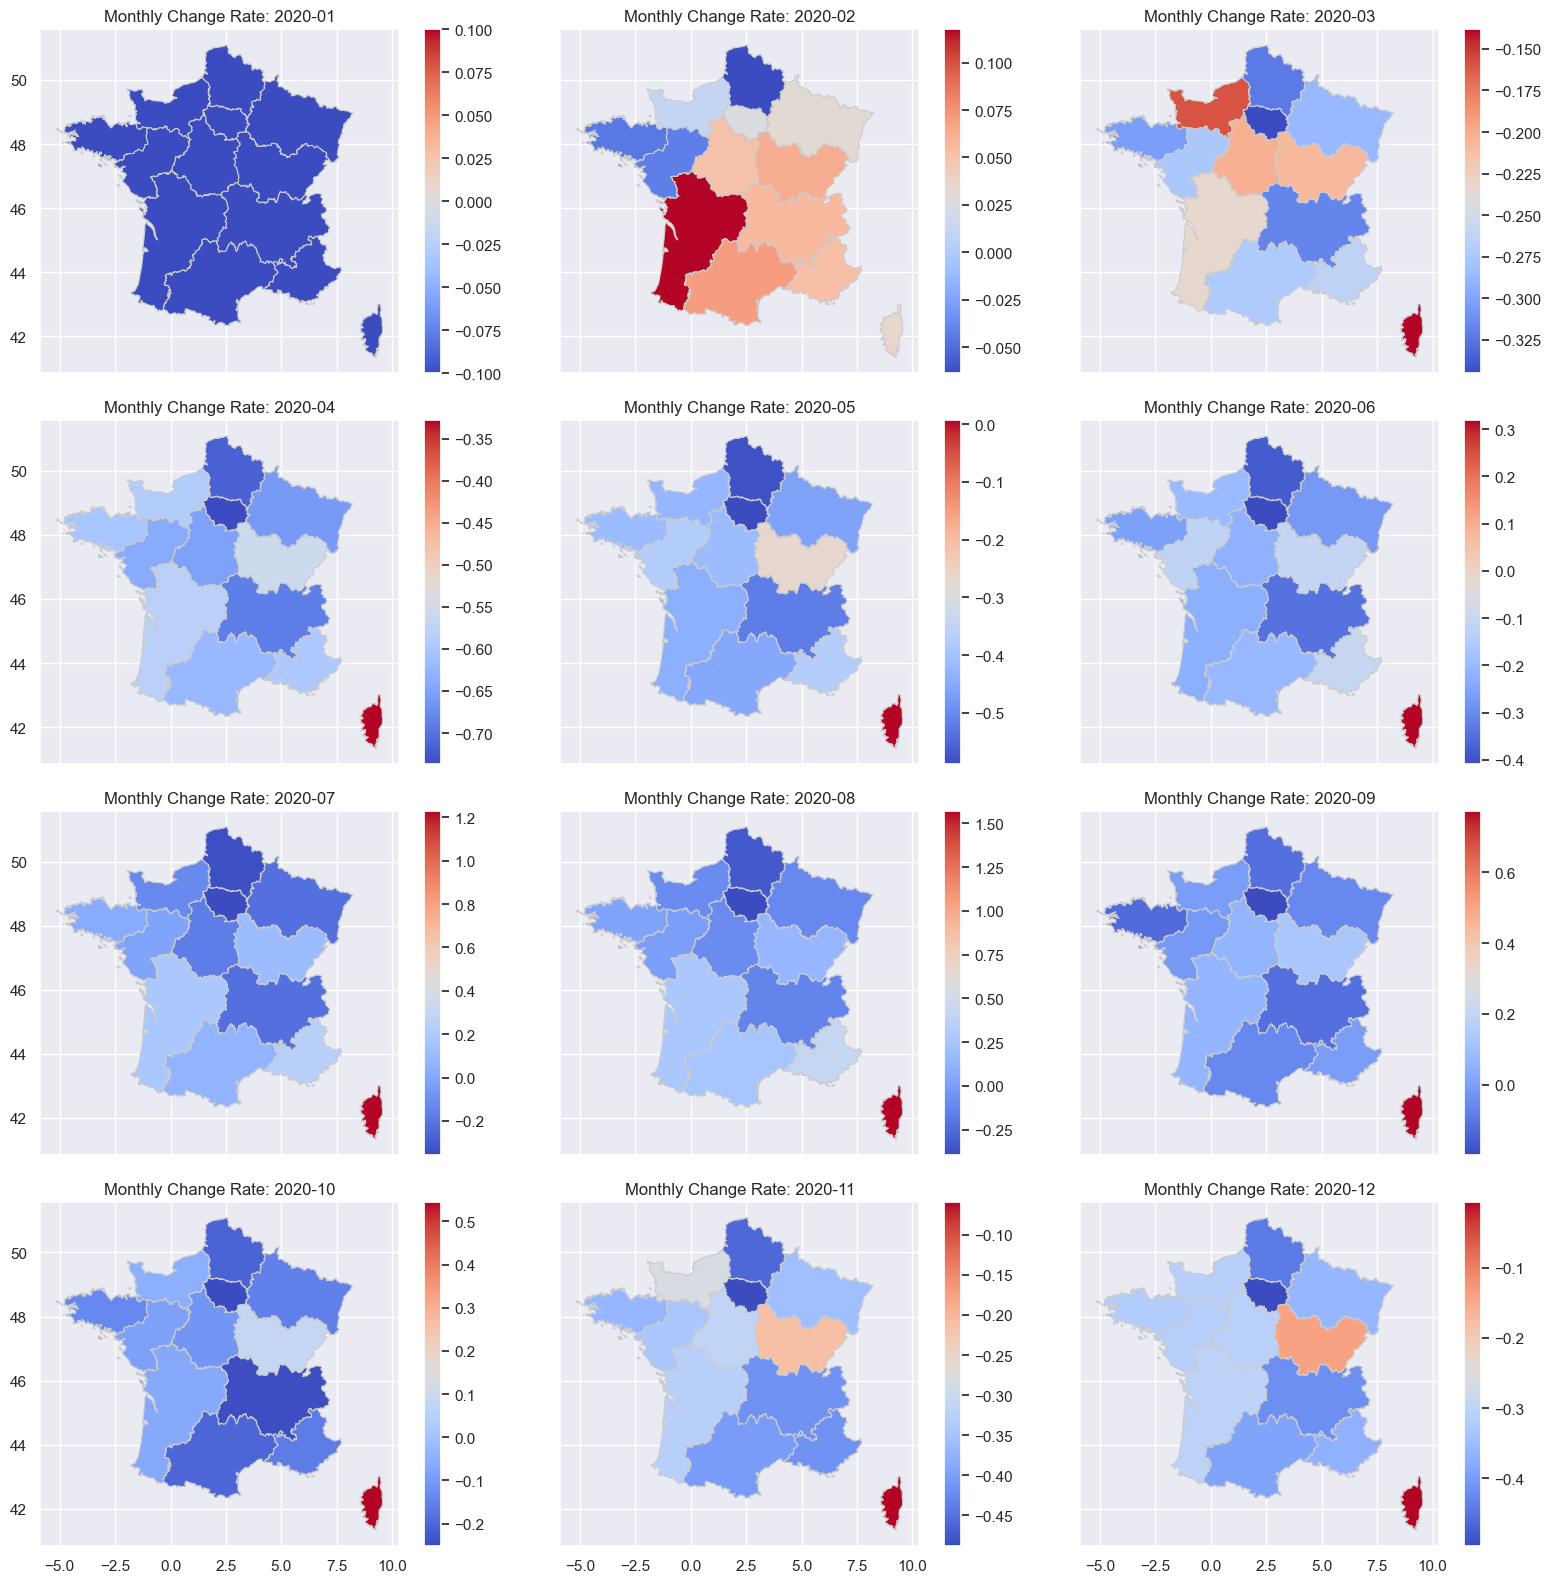

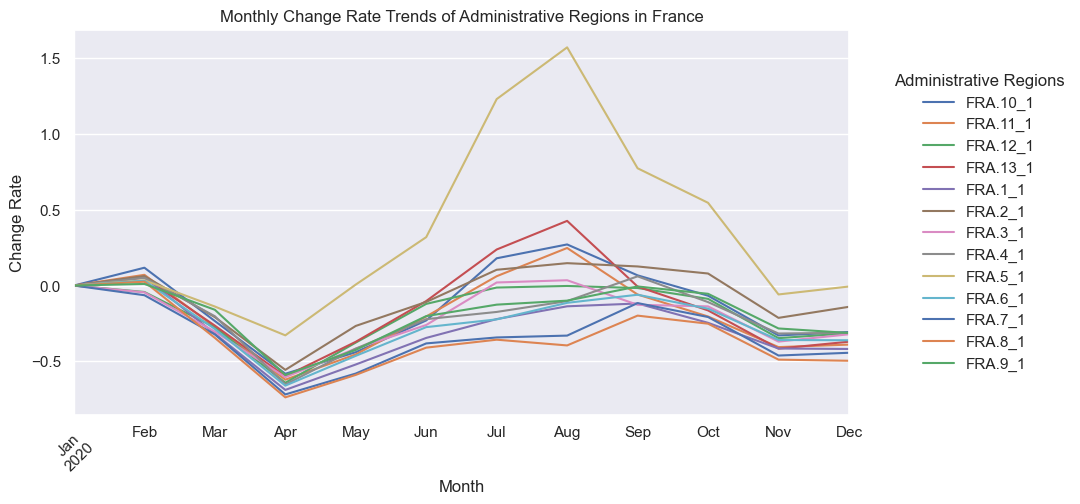

In [278]:
all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
all_code = all_operation_code_str + '\n' + solution.code_for_assembly
exec(all_code)

In [279]:
print(all_code)

import geopandas as gpd

def load_france_shp(france_shp_url="https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"):
    """
    Load France administrative regions shapefile
    
    france_shp_url: France Shapefile URL
    
    return: france_gdf, a Geopandas GeoDataFrame loaded from the shapefile
    """
    france_gdf = gpd.read_file(france_shp_url)
    return france_gdf
import pandas as pd
import requests
from io import StringIO

def get_mobility_data(mobility_api_url="http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020"):
    """
    Description: Get mobility data of regions via REST API
    Input:
        - mobility_api_url: REST API URL string to access mobility data
    Output:
        - mobility_data: Pandas DataFrame containing mobility data
    """
    response = requests.get(mobility_api_url)
    response_csv = response.content.decode("utf-8")
    mobi

In [280]:
stop

NameError: name 'stop' is not defined

In [ ]:
import geopandas as gpd

def load_france_shp(france_shp_url="https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"):
    """
    Description: Load France administrative regions shapefile

    Args:
    france_shp_url (str): URL of the zipped shapefile

    Returns:
    france_gdf (GeoDataFrame): GeoDataFrame containing the France administrative regions
    """
    france_gdf = gpd.read_file(france_shp_url)
    return france_gdf
import pandas as pd
import geopandas as gpd
import requests
from io import StringIO

def load_mobility_data(mobility_api_url="http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020"):
    """
    Load COVID-19 mobility data

    mobility_api_url: REST API url for COVID-19 mobility data
    returns: mobility_data (dataframe): Mobility data with place, date and intra_movement values
    """
    response = requests.get(mobility_api_url)
    data = StringIO(response.text)
    mobility_data = pd.read_csv(data)

    return mobility_data
def join_data(france_gdf=gpd.GeoDataFrame(), mobility_data=pd.DataFrame()):
    """
    Description: Join shapefile and mobility data

    Args:
    france_gdf (GeoDataFrame): GeoDataFrame containing the France administrative regions
    mobility_data (pd.DataFrame): Mobility data with place, date, and intra_movement values

    Returns:
    joined_data (GeoDataFrame): GeoDataFrame containing the joined shapefile and mobility data
    """
    # Convert GID_1 column to string type without leading zeros
    france_gdf["GID_1"] = france_gdf["GID_1"].astype(str).str.lstrip("0")

    # Convert place column to string type without leading zeros
    mobility_data["place"] = mobility_data["place"].astype(str).str.lstrip("0")

    # Merge mobility data with shapefile based on GID_1 and place columns
    joined_data = france_gdf.merge(mobility_data, left_on="GID_1", right_on="place")

    # Remove duplicates
    joined_data.drop_duplicates(subset=["GID_1", "date"], inplace=True)

    return joined_data
def calc_monthly_changes(joined_data=gpd.GeoDataFrame()):
    """
    Create monthly change rates
    
    Args:
    joined_data (gpd.GeoDataFrame): GeoDataFrame containing the joined shapefile and mobility data
    
    Returns:
    monthly_changes (pd.DataFrame): DataFrame with monthly change rates for each administrative region
    """
    # Parse dates and create a month-year column
    joined_data['date'] = pd.to_datetime(joined_data['date'])
    joined_data['month_year'] = joined_data['date'].dt.to_period('M')

    # Calculate the sum of intra_movement for each region and month-year
    region_monthly = joined_data.groupby(['NAME_1', 'month_year'])['intra_movement'].sum().reset_index()

    # Calculate the changes of each month based on January 2020
    base_month =  "2020-01" # pd.to_datetime("2020-01")
    print(region_monthly[region_monthly['month_year'] == "2020-01"])
    baseline = region_monthly[region_monthly['month_year'] == base_month].set_index('NAME_1')['intra_movement']
    print(baseline)
    region_monthly['change_rate'] = region_monthly.apply(lambda row: (row['intra_movement'] - baseline[row['NAME_1']]) / baseline[row['NAME_1']], axis=1)

    # Pivot month_year as columns to create monthly_changes DataFrame
    monthly_changes = region_monthly.pivot(index='NAME_1', columns='month_year', values='change_rate').reset_index()

    return monthly_changes
import matplotlib.pyplot as plt
import seaborn as sns

def matrix_map(monthly_changes=pd.DataFrame(), france_gdf=gpd.GeoDataFrame()):
    """
    Description: Create matrix of France maps

    Args:
    monthly_changes (pd.DataFrame): DataFrame with monthly change rates for each administrative region
    france_gdf (gpd.GeoDataFrame): GeoDataFrame containing the France administrative regions

    Returns:
    france_map_fig (Figure): Figure containing the matrix of France maps with monthly change rates
    """
    # Merge monthly_changes with france_gdf
    france_gdf = france_gdf.merge(monthly_changes, on="NAME_1")
    
    # Set up plot
    plt.style.use('seaborn-darkgrid')
    france_map_fig, axs = plt.subplots(3, 4, figsize=(24, 18), sharex='col', sharey='row')
    france_map_fig.suptitle('Monthly change rates of each administrative region in France')

    # Iterate through columns for each month
    for idx, month_year in enumerate(monthly_changes.columns[1:]):
        row, col = divmod(idx, 4)
        
        # Create subplot
        france_gdf.plot(column=month_year, ax=axs[row, col], legend=True, cmap='coolwarm', legend_kwds={'shrink': 0.8})
        axs[row, col].set_title(month_year.strftime("%B %Y"))
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
        axs[row, col].set_xlabel("")
        axs[row, col].set_ylabel("")
        
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    
    return france_map_fig
import matplotlib.pyplot as plt
import seaborn as sns

def chart_matrix(monthly_changes=pd.DataFrame()):
    """
    Description: Create chart matrix of each administrative region's line chart

    Args:
    monthly_changes (pd.DataFrame): DataFrame with monthly change rates for each administrative region

    Returns:
    line_chart_matrix_fig (matplotlib.figure.Figure): Figure object containing the line chart matrix
    """
    # Set default seaborn style
    sns.set()

    # Prepare monthly_changes data
    monthly_changes_tidy = pd.melt(monthly_changes, 
                                   id_vars=["NAME_1"], 
                                   var_name="month_year", 
                                   value_name="change_rate")
    monthly_changes_tidy["month_year"] = monthly_changes_tidy["month_year"].astype(str)

    # Calculate the number of rows and columns for the line chart matrix
    n_regions = len(monthly_changes["NAME_1"].unique())
    n_cols = min(4, n_regions)
    n_rows = (n_regions // n_cols) + (1 if (n_regions % n_cols) else 0)

    # Create the line chart matrix
    line_chart_matrix_fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5), sharex=True, sharey=True)

    for idx, (name, group) in enumerate(monthly_changes_tidy.groupby(["NAME_1"])):
        row, col = divmod(idx, n_cols)

        ax = axes[row][col]
        sns.lineplot(x="month_year", y="change_rate", data=group, ax=ax)
        ax.set_title(name)
        ax.set_xticklabels(labels=group["month_year"].unique(), rotation=45)

    # Remove empty subplots
    for idx in range(n_regions, n_rows * n_cols):
        row, col = divmod(idx, n_cols)
        axes[row][col].remove()

    # Adjust layout
    line_chart_matrix_fig.tight_layout()

    return line_chart_matrix_fig
import matplotlib.pyplot as plt

def overall_trends_line_chart(monthly_changes=pd.DataFrame()):
    """
    Description: Draw the line chart for all administrative regions

    Args:
    monthly_changes (pd.DataFrame): DataFrame with monthly change rates for each administrative region

    Returns:
    trends_line_chart_fig (matplotlib.figure.Figure): Figure containing the line chart for all administrative regions
    """
    # Transpose monthly_changes DataFrame
    transposed_changes = monthly_changes.set_index("NAME_1").transpose()

    # Create line chart
    trends_line_chart_fig, ax = plt.subplots(figsize=(12, 8))
    transposed_changes.plot(ax=ax)
    plt.xlabel("Month")
    plt.ylabel("Change Rate")
    plt.title("Monthly Trends of Change Rates for All Administrative Regions")
    plt.legend(title="Regions", labels=transposed_changes.columns, bbox_to_anchor=(1.17, 1))
    plt.xticks(range(len(transposed_changes.index)), transposed_changes.index, rotation=90)

    return trends_line_chart_fig

# Example usage
# france_gdf = load_france_shp()
# mobility_data = load_mobility_data()
# joined_data = join_data(france_gdf, mobility_data)
# monthly_changes = calc_monthly_changes(joined_data)
# trends_line_chart_fig = overall_trends_line_chart(monthly_changes)
# plt.show()
import geopandas as gpd
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns


 
# Load data
monthly_changes = calc_monthly_changes(joined_data)

# Create and save monthly change maps
france_map_fig = matrix_map(monthly_changes, france_gdf)
france_map_fig.savefig('france_monthly_change_maps.png')

# Create and save chart matrix with line charts of each administrative region
line_chart_matrix_fig = chart_matrix(monthly_changes)
line_chart_matrix_fig.savefig('chart_matrix_line_charts.png')

# Create and save overall trends line chart
trends_line_chart_fig = overall_trends_line_chart(monthly_changes)
trends_line_chart_fig.savefig('overall_trends_line_chart.png')

plt.show()


In [ ]:
joined_data#.plot()